# Exercise 3
Skipping the creation of new data and using the data genereated during the leasson.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

import pandas as pd
from scipy import stats

import seaborn 
from sklearn import metrics

from sklearn.metrics import classification_report
from sklearn import preprocessing


input_shape = (60, 1)
n_class = 3


def create_model(NCONV = 1,NF = 5,reg_type = 1,reg_lambda = 0.5):

    # reproducibility
    np.random.seed(12345)
    import tensorflow.random as tf_r
    tf_r.set_seed(12345)

    ## from keras import regularizers, initializers
    if reg_type == 2:
        reg = tf.keras.regularizers.l2(reg_lambda) ## raised to 0.2

    elif reg_type == 1:
        reg = tf.keras.regularizers.l1(reg_lambda)

    ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, 
                                            seed=None)
    

    # challenge: at most 600 tunable parameters
    model = Sequential()
    # 
    
    if NCONV==1:
        # -----2-----
        model.add(Conv1D(filters=NF, kernel_size=11, 
                        kernel_initializer=ini, 
                        kernel_regularizer=reg,
                        activation='relu', 
                        input_shape=input_shape))
        #model.add(MaxPooling1D(3))
        model.add(AveragePooling1D(5))
        model.add(Conv1D(filters=5, kernel_size=7, 
                        activation='relu'))
        model.add(Flatten())
        model.add(Dense(12, activation='relu'))
        model.add(Dropout(0.2))
    # 
    if NCONV==2:
        # -----1-----
        model.add(Conv1D(filters=NF, kernel_size=11, 
                        kernel_initializer=ini, 
                        kernel_regularizer=reg, ######## TRY WITHOUT !
                        activation='relu', input_shape=input_shape))
        #model.add(MaxPooling1D(3))
        model.add(AveragePooling1D(5))
        model.add(Flatten())
        model.add(Dense(9, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(6, activation='relu'))
        model.add(Dropout(0.2))
        #model.add(Dense(10, activation='relu'))
        #model.add(Dropout(0.3))
    model.add(Dense(n_class, activation='softmax')) # softmax !

    # print('----- Model',NCONV,'-----')
    # print(model.summary())

    # optimizers
    # .SGD(lr=0.01, momentum=0.9, nesterov=True) # decay=1e-6,
    # .RMSprop()
    # .Nadam()
    opt = tf.keras.optimizers.Adam()

    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=opt,metrics=['accuracy'])
    
    return model



def load_data(filename, perc_train = 0.8):
    str0 = filename
    fnamex='DATA/x_'+str0
    fnamey='DATA/y_'+str0
    

    x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
    N,L = len(x), len(x[0])


    categ = np.loadtxt(fnamey, dtype=int)
    n_class = 3    # y.argmax() - y.argmin() +1
    # print('data: ',N)

    y = np.zeros((N,n_class))
    for i in range(N):
        y[i][categ[i]] = 1.

    # rescaling stuff
    xm = x.mean(axis=1)
    for i in range(N):
        x[i] = x[i]-xm[i]
    
    x = x/400

    N_train = int(perc_train*N)
    x_train = x[:N_train]
    y_train = y[:N_train]
    x_val = x[N_train:]
    y_val = y[N_train:]
    N_val = len(x_val)

    
    x_train = x_train.reshape(x_train.shape[0], L, 1)
    x_val =  x_val.reshape(x_val.shape[0], L, 1)

    return x_train,y_train,x_val,y_val



def Show_weights(model,ax1,ax2,l=0,label="model"):
    c=['r','y','c','b','m']
    m=['o','s','D','<','>']
    ms=10
    
    w = model.layers[l].get_weights()[0]
    wT=w.T
    M=len(wT)
    b = model.layers[l].get_weights()[1]
    
    ax1.axhline(0, c="k")
    ax1.plot((0,))
    for i in range(M):
        ax1.plot(wT[i][0],"-",c=c[i],marker=m[i],label=str(i),markersize=ms)
    ax1.set_title(label+': filters of layer '+str(l))
    ax1.set_xlabel('index')
    
    ax2.axhline(0, c="k")
    for i in range(M):
        ax2.plot((i),(b[i]),c=c[i],marker=m[i],label="filter "+str(i),markersize=ms)
    ax2.set_title(label+': bias of layer '+str(l))
    ax2.set_xlabel('filter nr')
    ax2.set_xticks(np.arange(5))
    ax2.legend()
    
def Show_history(fit,ax1,ax2):
    ax1.plot(fit.history['accuracy'],"b",label="train")
    ax1.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax1.plot((0,len(fit.history['val_accuracy'])),(1/3,1/3),":",c="gray",label="random choice")
    ax1.set_xlabel('epoch')
    ax1.set_ylabel("Accuracy")
    ax1.set_ylim([0, 1])
    ax1.legend()
    
    ax2.plot(fit.history['loss'],"b",label="train")
    ax2.plot(fit.history['val_loss'],"r--",label="valid.")
    ax2.set_xlabel('epoch')
    ax2.set_ylabel("Loss")
    ax2.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax2.legend()

LABELS = ["absent","positive","negative"]
cmap="GnBu"

def show_confusion_matrix(validations, predictions, label="Model",axis = None):

    if axis == None:
        matrix = metrics.confusion_matrix(validations, predictions)
        plt.figure(figsize=(6, 5))
        seaborn.heatmap(matrix,
                    xticklabels=LABELS,
                    yticklabels=LABELS,
                    annot=True,
                    fmt='d',
                    linecolor='white',
                    linewidths=1,
                    cmap=cmap)
        plt.title(label+': Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
    else:
        matrix = metrics.confusion_matrix(validations, predictions)
        seaborn.heatmap(matrix,
                    xticklabels=LABELS,
                    yticklabels=LABELS,
                    annot=True,
                    fmt='d',
                    linecolor='white',
                    linewidths=1,
                    cmap=cmap,
                    ax = axis)
        axis.set_title(label+': Confusion Matrix')
        axis.set_ylabel('True Label')
        axis.set_xlabel('Predicted Label')



# 2 Varrying the Amplitude

A :2000, Final validation accuracy 1.0  validation loss 1.3885400221624877e-05
A :1000, Final validation accuracy 0.9994999766349792  validation loss 0.0011208669748157263
A :500, Final validation accuracy 0.9785000085830688  validation loss 0.06769706308841705
A :250, Final validation accuracy 0.6710000038146973  validation loss 0.7515584826469421
A :125, Final validation accuracy 0.42149999737739563  validation loss 1.0761593580245972
A :50, Final validation accuracy 0.35350000858306885  validation loss 1.1000524759292603


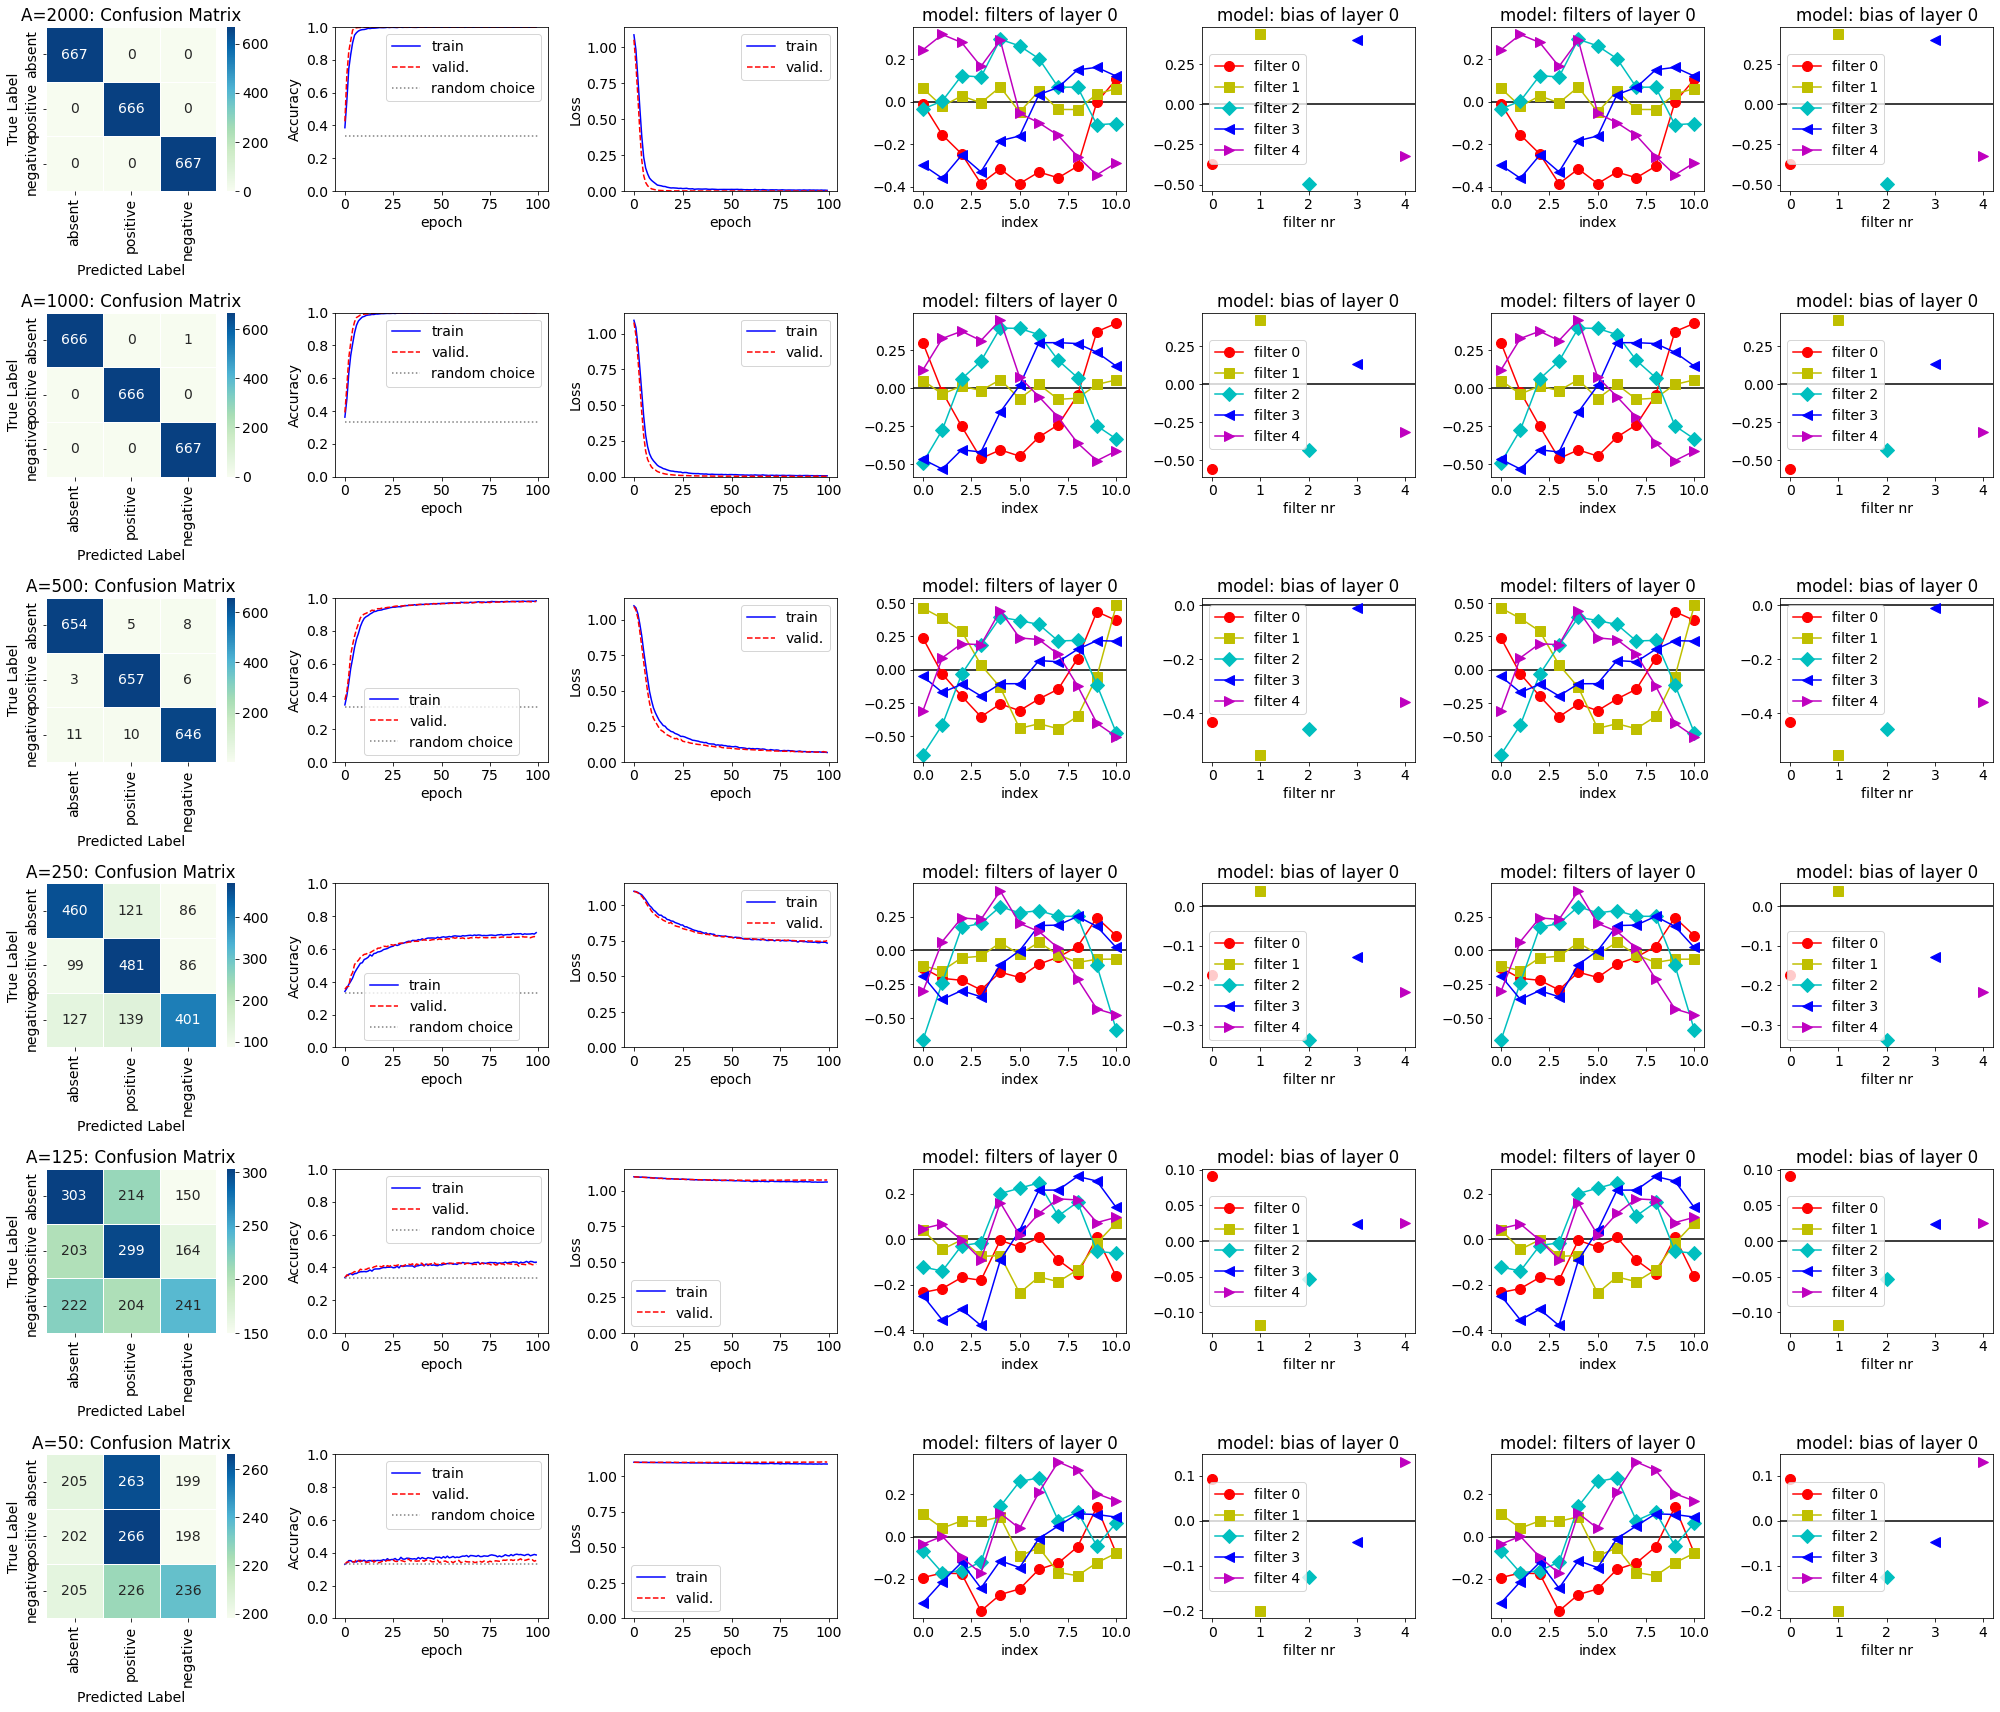

In [3]:
As = [2000,1000,500,250,125,50]
nA = len(As)
fig,axis = plt.subplots(nA,7,figsize = (28,4*nA))
BATCH_SIZE = 250
EPOCHS = 100


for A,ax in zip(As,axis):
    str0 = f'ts_L60_Z12_A{A}_DX50_bias5_N10000.dat'
    model = create_model(reg_lambda=0)
    x_train,y_train,x_val,y_val = load_data(str0)

    fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,
                    validation_data=(x_val, y_val), verbose=0, shuffle=True) 

    y_pred_val = model.predict(x_val)
    # Take the class with the highest probability from the val predictions
    max_y_val = np.argmax(y_val, axis=1)
    max_y_pred_val = np.argmax(y_pred_val, axis=1)

    show_confusion_matrix(max_y_val, max_y_pred_val,f"A={A}",axis=ax[0])
    Show_history(fit,ax[1],ax[2])
    Show_weights(model,ax[3],ax[4],0)
    Show_weights(model,ax[5],ax[6],0)
    print(f"A :{A}, Final validation accuracy",fit.history["val_accuracy"][-1]," validation loss",fit.history["val_loss"][-1])

plt.tight_layout()
plt.show()

Form the above one sees that when you drop below amplitude versus noise ratio of 10, there is a dramastic decrease. Also one sees the general trend one would expect. That there is a increase in the accuracy as the amplitude gets larger and the model learns faster. 

# 3 Varrying the lambda
## L1 (LASSO)

lambda :0, Final validation accuracy 0.9785000085830688  validation loss 0.06769706308841705
lambda :1e-05, Final validation accuracy 0.9760000109672546  validation loss 0.07260198891162872
lambda :0.0001, Final validation accuracy 0.9800000190734863  validation loss 0.06668681651353836
lambda :0.001, Final validation accuracy 0.9819999933242798  validation loss 0.07255873829126358
lambda :0.01, Final validation accuracy 0.9764999747276306  validation loss 0.11979610472917557
lambda :0.1, Final validation accuracy 0.8529999852180481  validation loss 0.41443517804145813
lambda :1, Final validation accuracy 0.3330000042915344  validation loss 1.104809284210205


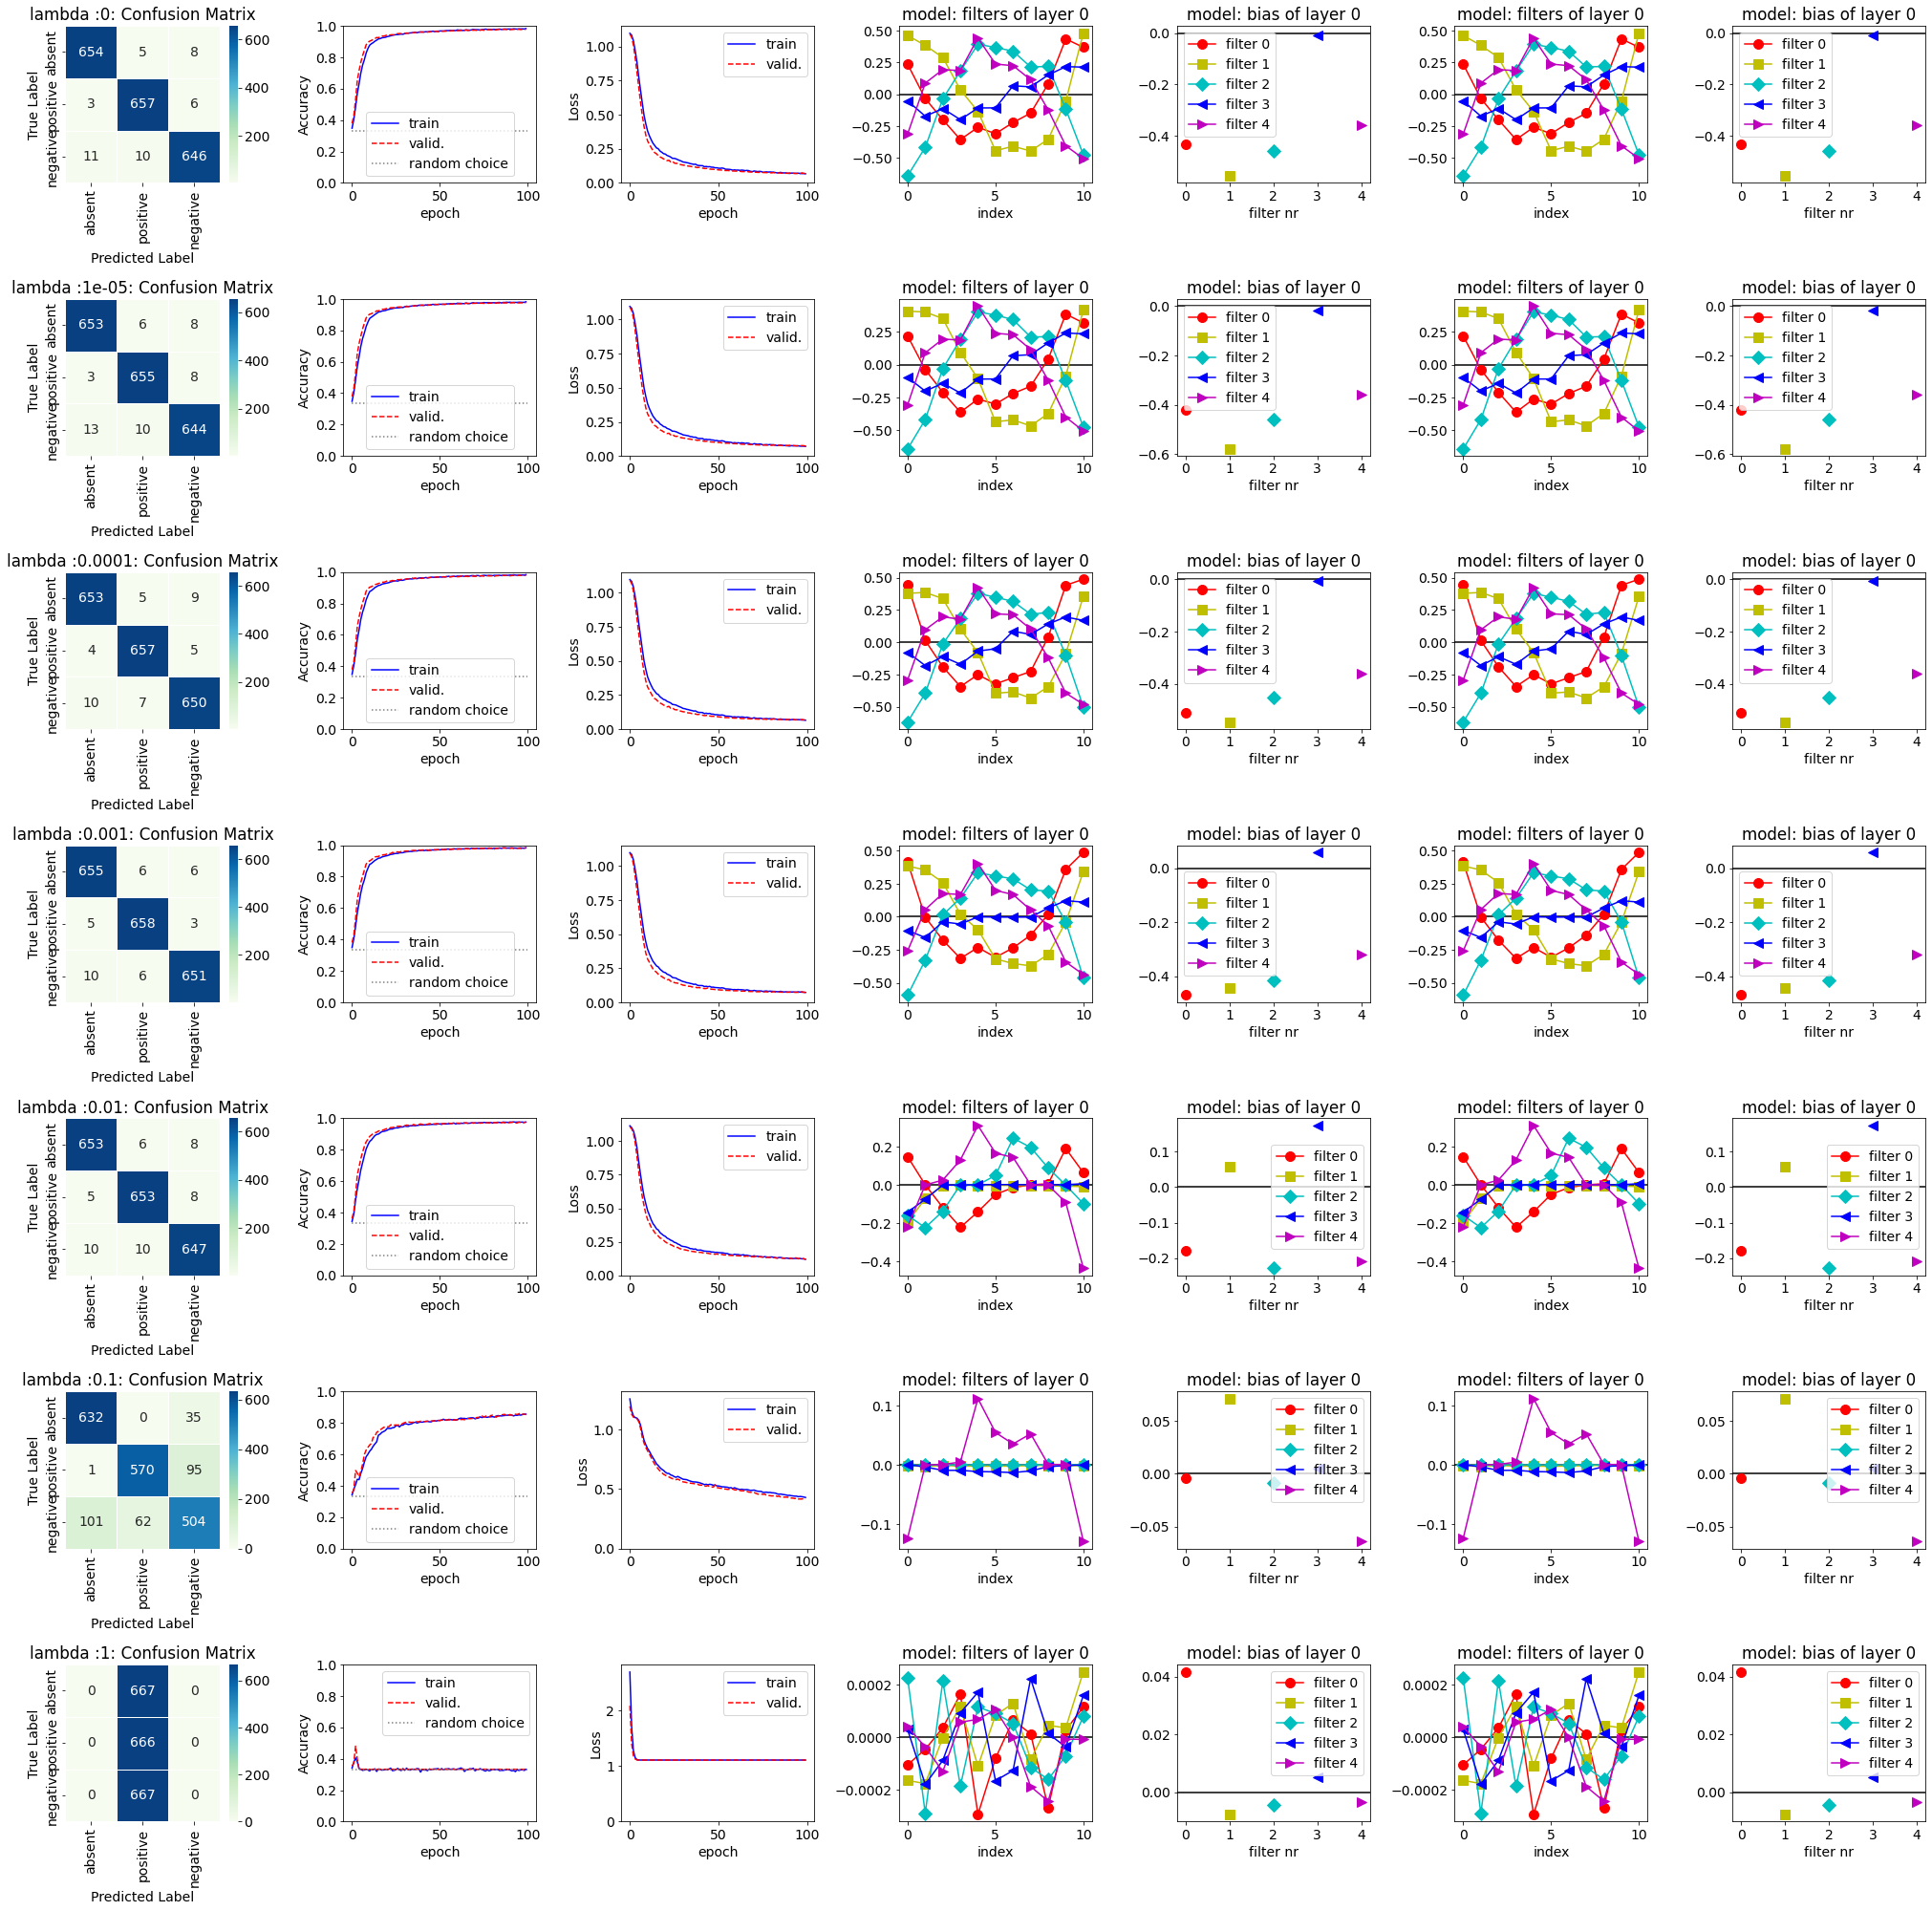

In [9]:
str0 = f'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
x_train,y_train,x_val,y_val = load_data(str0)

reg_lambdas = [0,1e-5,1e-4,1e-3,1e-2,1e-1,1]
nA = len(reg_lambdas)
fig,axis = plt.subplots(nA,7,figsize = (28,4*nA))

for reg_lambda,ax in zip(reg_lambdas,axis):
    model = create_model(reg_lambda=reg_lambda)

    fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,
                    validation_data=(x_val, y_val), verbose=0, shuffle=True) 

    y_pred_val = model.predict(x_val)
    # Take the class with the highest probability from the val predictions
    max_y_val = np.argmax(y_val, axis=1)
    max_y_pred_val = np.argmax(y_pred_val, axis=1)

    label = f"lambda :{reg_lambda}"
    show_confusion_matrix(max_y_val, max_y_pred_val,label,axis=ax[0])
    Show_history(fit,ax[1],ax[2])
    Show_weights(model,ax[3],ax[4],0)
    Show_weights(model,ax[5],ax[6],0)
    print(f"lambda :{reg_lambda}, Final validation accuracy",fit.history["val_accuracy"][-1]," validation loss",fit.history["val_loss"][-1])

plt.tight_layout()
plt.show()

From the above on sees that the optimal value for lambda when using L1-reguralization is between $0.001$ and $0.0001$. The effect is also so clear on the size of the weights, when the lambda is increased the value of weights are smaller. But since the bias is not effected by this reguralization one has the same size of this for all lambda values.

## L2 (Ridge)

lambda :0, Final validation accuracy 0.9785000085830688  validation loss 0.06769706308841705
lambda :1e-05, Final validation accuracy 0.9760000109672546  validation loss 0.07097212970256805
lambda :0.0001, Final validation accuracy 0.9769999980926514  validation loss 0.07095003873109818
lambda :0.001, Final validation accuracy 0.9825000166893005  validation loss 0.06569752842187881
lambda :0.01, Final validation accuracy 0.9819999933242798  validation loss 0.07867487519979477
lambda :0.1, Final validation accuracy 0.9739999771118164  validation loss 0.10337083041667938
lambda :1, Final validation accuracy 0.9729999899864197  validation loss 0.12881457805633545
lambda :10, Final validation accuracy 0.8525000214576721  validation loss 0.4354960024356842


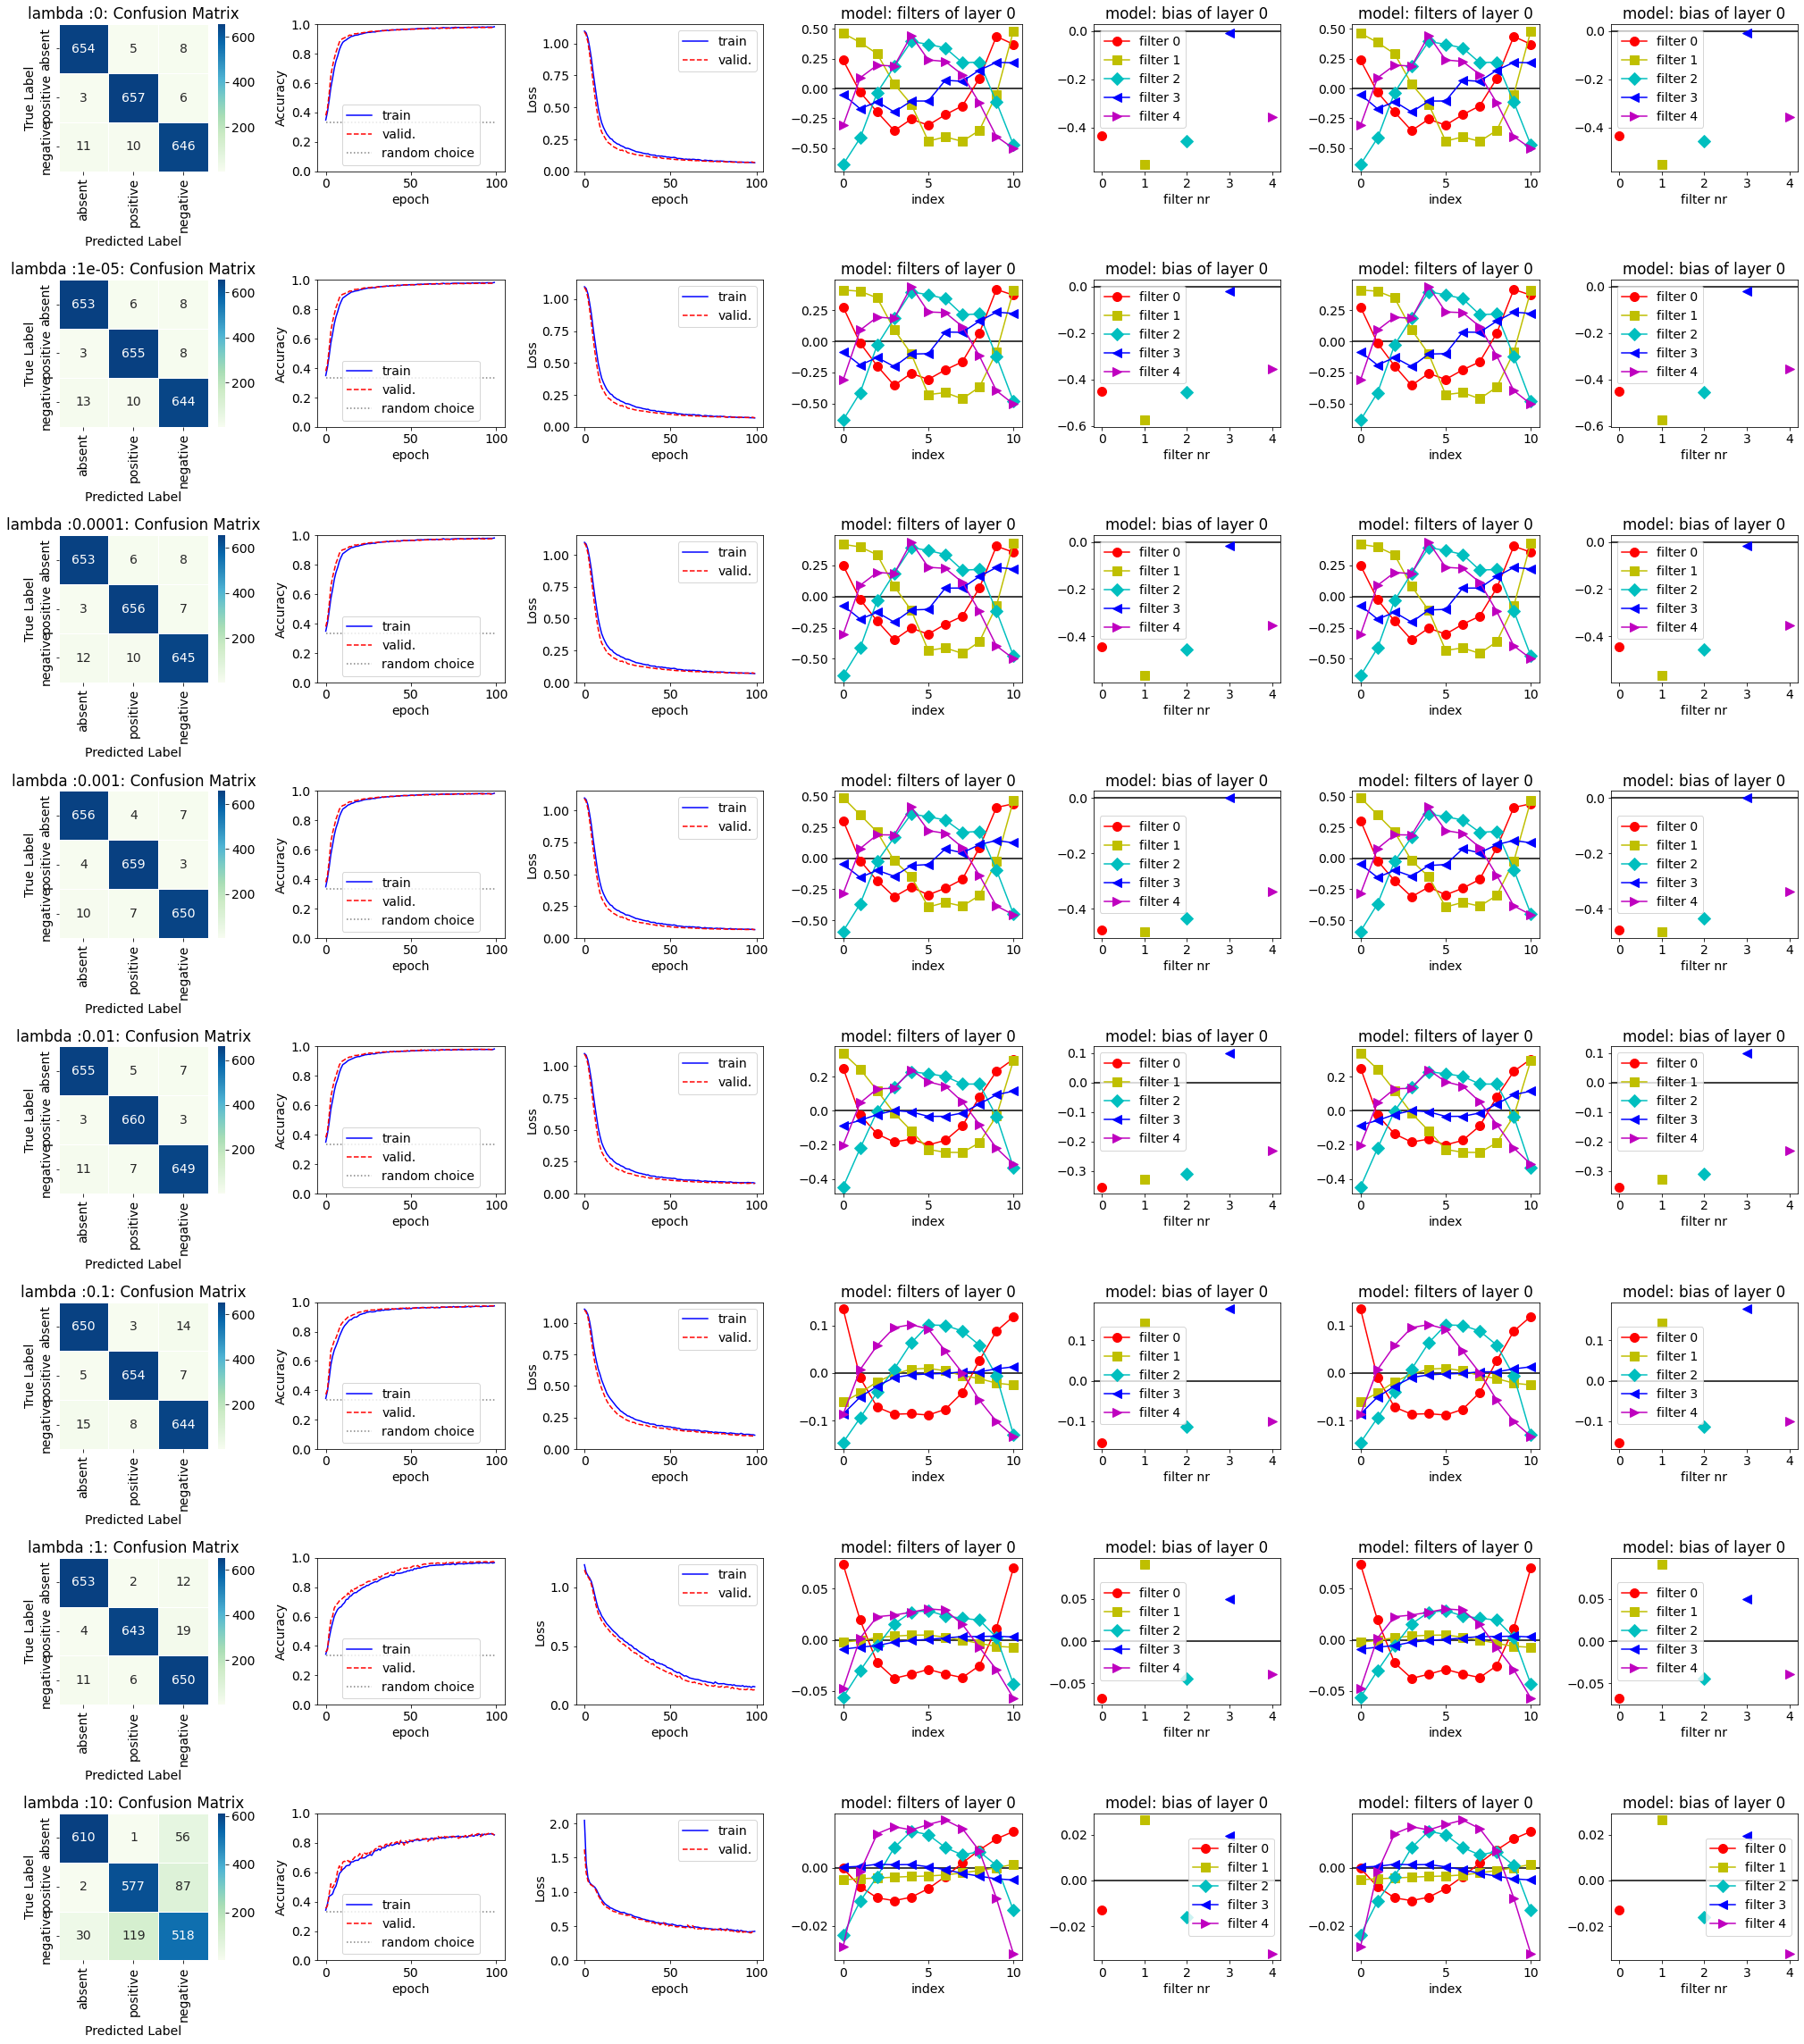

In [10]:
str0 = f'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
x_train,y_train,x_val,y_val = load_data(str0)

reg_lambdas = [0,1e-5,1e-4,1e-3,1e-2,1e-1,1,10]
nA = len(reg_lambdas)
fig,axis = plt.subplots(nA,7,figsize = (28,4*nA))

for reg_lambda,ax in zip(reg_lambdas,axis):
    model = create_model(reg_lambda=reg_lambda,reg_type=2)

    fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,
                    validation_data=(x_val, y_val), verbose=0, shuffle=True) 

    y_pred_val = model.predict(x_val)
    # Take the class with the highest probability from the val predictions
    max_y_val = np.argmax(y_val, axis=1)
    max_y_pred_val = np.argmax(y_pred_val, axis=1)

    label = f"lambda :{reg_lambda}"
    show_confusion_matrix(max_y_val, max_y_pred_val,label,axis=ax[0])
    Show_history(fit,ax[1],ax[2])
    Show_weights(model,ax[3],ax[4],0)
    Show_weights(model,ax[5],ax[6],0)
    print(f"lambda :{reg_lambda}, Final validation accuracy",fit.history["val_accuracy"][-1]," validation loss",fit.history["val_loss"][-1])

plt.tight_layout()
plt.show()

From the above one sees that the optimal value for the L2-reguralization is between $0.001$ and $0.01$. The value obtained for the L2 is 10 times higher than the L1 reguralization. Also here as for the L1 case one sees the effect of the lambda size on the weights of the layers.